In [1]:
# !pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

In [2]:
import tensorflow as tf
import os, random
import numpy as np

# Seed everything for reproducability
SEED = 42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [3]:
import re, json, ast, cv2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

PATH = 'D:\Datasets\hpa-single-cell-image-classification'
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
train_tfr = os.listdir(os.path.join(PATH, 'train_tfrecords'))
test_tfr = os.listdir(os.path.join(PATH, 'test_tfrecords'))
train_images = os.listdir(os.path.join(PATH, 'train'))
test_images = os.listdir(os.path.join(PATH, 'test'))
label_names = pd.read_csv(os.path.join(PATH, 'label_codes.csv')).label_name.to_list()
submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

print("TrainV0 dataframe shape:", train_df.shape)
print("Number of train images:", len(train_images))
print("Number of test images:", len(test_images))
print("Number of unique labels:", len(label_names))

TrainV0 dataframe shape: (21806, 4)
Number of train images: 87224
Number of test images: 2236
Number of unique labels: 19


In [4]:
# Image width and height have been included beforehand
train_df.head(3)

,ID,Label,width,height
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0,2048,2048
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,2048,2048
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,3072,3072


In [5]:
submission.head(3)

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==


In [6]:
def label_splitter(labels):
    for label in labels:
        sparse_label = [0] * len(label_names)
        for e in labels.split('|'):
            sparse_label[int(e)] = 1
    return sparse_label

train_paths = [i + "_green.png" for i in train_df['ID']]
train = pd.DataFrame({'image_path': train_paths})
labels = pd.DataFrame.from_records(train_df['Label'].apply(label_splitter))
train['labels'] = train_df['Label']
train = pd.concat([train, labels], axis=1)
train.head(3)

,image_path,labels,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_green.png,8|5|0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0_green.png,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0_green.png,6|1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


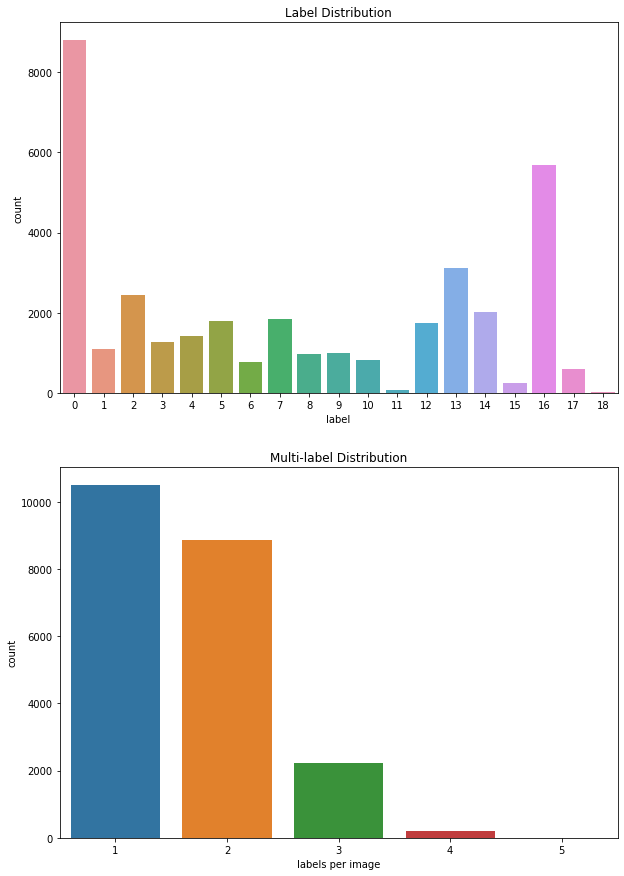

<Figure size 720x720 with 0 Axes>

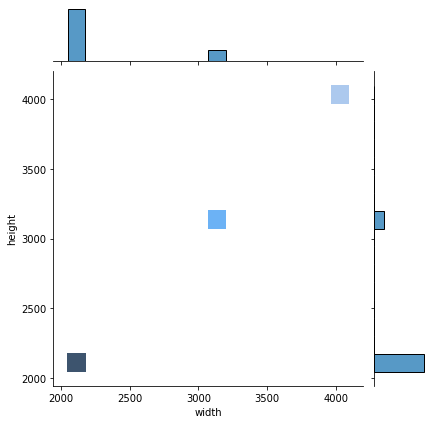

In [7]:
counts = []
for column in range(0,19):
    counts.append(train[column].sum(axis=0))

count_df = pd.DataFrame({'label': range(0,19), 'count':counts})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,15))
sns.barplot(data=count_df, x='label', y='count', ax=ax1)
ax1.set_title('Label Distribution')
sns.countplot(x=train.iloc[:, 1::].sum(axis=1), ax=ax2)
ax2.set_title('Multi-label Distribution')
ax2.set_xlabel('labels per image')
plt.show()

plt.figure(figsize=(10,10))
sns.jointplot(x=train_df['width'], y=train_df['height'], kind="hist")
plt.show()

#### Single-Labelled Distribution
There is an imbalanced distribution in the dataset therefore we will need to stratify the dataset by class 0.

#### Multi-labelled Distribution
Most of the images are singularly labelled

#### Image shape Distribution
The images fall into 3 subclasses of squared shape;
- 2048 x 2048
- 3072 x 3072
- 4096 x 4096

We will resize the images to 2048 x 2048 for standardization.

# Removing duplicates

## Detecting duplicates by image-hashing

In [8]:
# import imagehash
# from tqdm.notebook import tqdm
# from PIL import Image
# import torch

# funcs = [
#         imagehash.average_hash,
#         imagehash.phash,
#         imagehash.dhash,
#         imagehash.whash,
#     ]
# image_ids = []
# hashes = []

# IMG_PATH = r'D:\Datasets\hpa-single-cell-image-classification\train'

# for path in tqdm(train['image_path'], desc='Hashing images'):
#     image = Image.open(os.path.join(IMG_PATH, path))
#     image_id = os.path.basename(path)
#     image_ids.append(image_id)
#     hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

# hashes_all = np.array(hashes)
# hashes_all = torch.Tensor(hashes_all.astype(int))
# sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).numpy()/256 for i in tqdm(range(hashes_all.shape[0]), desc='Calculating similarities')])

# indices1 = np.where(sims > 0.9)
# indices2 = np.where(indices1[0] != indices1[1])
# image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
# image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
# dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}
# duplicate_image_ids = sorted(list(dups))
# print('Found %d duplicates' % len(duplicate_image_ids))

# # Remove duplicates from external data
# imgs_to_remove = [x[1] for x in duplicate_image_ids]

remove_index = pd.read_csv(os.path.join(PATH, 'remove_images_index.csv'))
remove_index = remove_index.merge(train[['image_path', 'labels']], left_on='image_x', right_on='image_path', how='inner').drop("image_path", axis=1)
remove_index = remove_index.merge(train[['image_path', 'labels']], left_on='image_y', right_on='image_path', how='inner').drop("image_path", axis=1)
print('{} duplicates detected'.format(remove_index.shape[0]))
remove_index.sample(10)

485 duplicates detected


,image_x,image_y,labels_x,labels_y
419,a23d1a8e-bbbd-11e8-b2ba-ac1f6b6435d0_green.png,cd895e1a-bba8-11e8-b2ba-ac1f6b6435d0_green.png,16|0,16|0
475,dece6094-bba8-11e8-b2ba-ac1f6b6435d0_green.png,f18ddcb6-bbab-11e8-b2ba-ac1f6b6435d0_green.png,4,4
181,2e8058be-bb9e-11e8-b2b9-ac1f6b6435d0_green.png,8c55b926-bba7-11e8-b2ba-ac1f6b6435d0_green.png,2|0,2|0
447,bac3a12c-bba9-11e8-b2ba-ac1f6b6435d0_green.png,e33fb0b8-bbb4-11e8-b2ba-ac1f6b6435d0_green.png,4|13,4|13
406,98e81aea-bbc9-11e8-b2bc-ac1f6b6435d0_green.png,be9292fe-bbbd-11e8-b2ba-ac1f6b6435d0_green.png,14,14
148,251f4e86-bbaf-11e8-b2ba-ac1f6b6435d0_green.png,e1aed506-bba2-11e8-b2b9-ac1f6b6435d0_green.png,0,0
381,85ea06be-bbb6-11e8-b2ba-ac1f6b6435d0_green.png,d2e56ad8-bbc7-11e8-b2bc-ac1f6b6435d0_green.png,16|8,16|8
338,698a2fba-bb9a-11e8-b2b9-ac1f6b6435d0_green.png,ea0f98a0-bb9f-11e8-b2b9-ac1f6b6435d0_green.png,0,0
480,eac7a5fe-bba3-11e8-b2b9-ac1f6b6435d0_green.png,f6818aee-bb9a-11e8-b2b9-ac1f6b6435d0_green.png,12|0,12|0
228,41e3ae98-bbc0-11e8-b2bb-ac1f6b6435d0_green.png,bea8f790-bbc9-11e8-b2bc-ac1f6b6435d0_green.png,16|0,16|0


### Image_x

In [9]:
def display_duplicates(list_of_images):
    plt.figure(figsize=(10,10))
    for i, IMAGE_PATH in enumerate(list_of_images):
        plt.subplot(3,3, i+1)
        image = cv2.imread(os.path.join(PATH, 'train', IMAGE_PATH), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

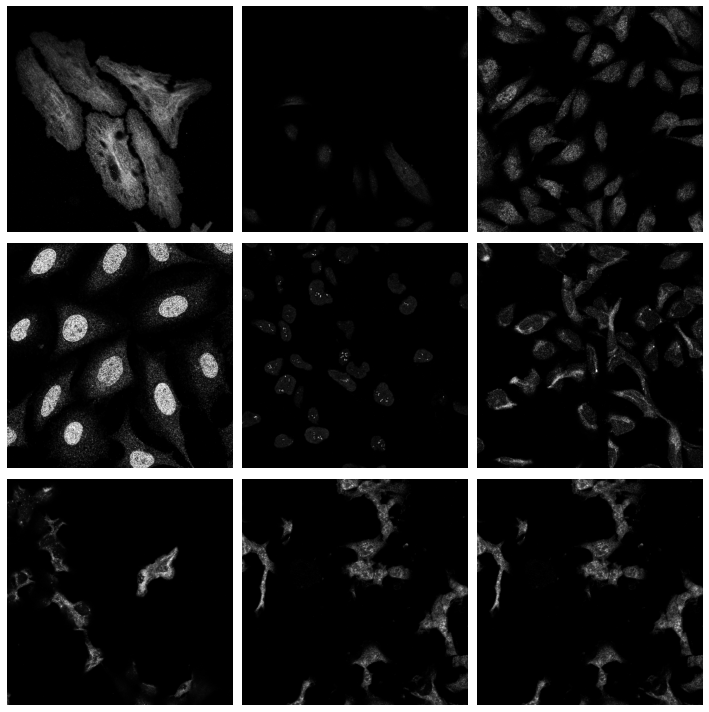

In [10]:
display_duplicates(remove_index.iloc[:9, :]['image_x'].to_list())

### Image_y

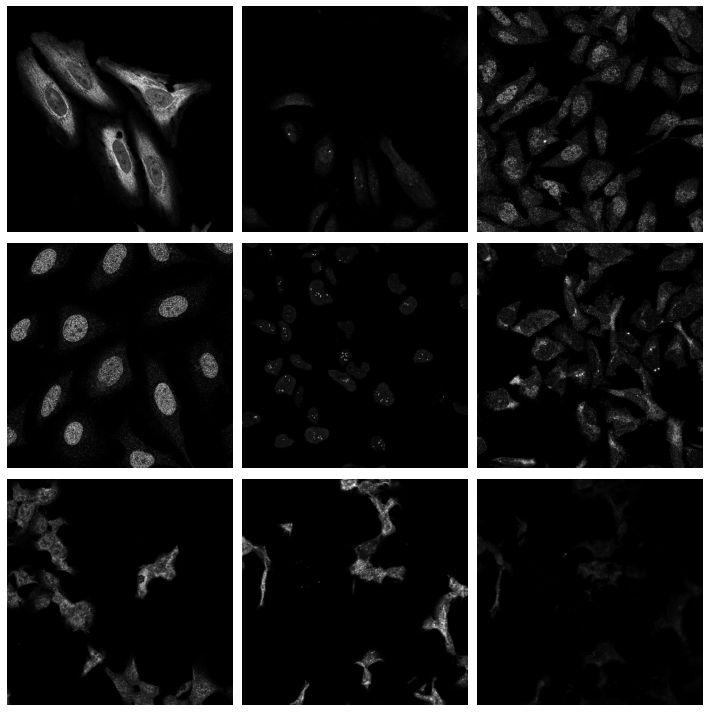

In [11]:
display_duplicates(remove_index.iloc[:9, :]['image_y'].to_list())

## Filter duplicated images

Based on the images above, the images were not completely equal with difference in constrast levels despite having identical labels. 

This would cause a conflict in categorization and biasness if left in our dataset, thus needs to be removed.

Images were converted to HSV format to obtain the constrast value of the image.
The lower constrast of the pair was removed.

In [12]:
# list_1 = []; list_2 = []

# for i, IMAGE_PATH in tqdm(enumerate(remove_index['image_0'].to_list())):
#     image = cv2.imread(os.path.join(PATH, 'train', IMAGE_PATH))
#     h,s,v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
#     list_1.append(v.mean())

# remove_index['image_0_v'] = list_1

# for i, IMAGE_PATH in tqdm(enumerate(remove_index['image_1'].to_list())):
#     image = cv2.imread(os.path.join(PATH, 'train', IMAGE_PATH))
#     h,s,v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
#     list_2.append(v.mean())

# remove_index['image_1_v'] = list_2

# remove_index['image_final'] = remove_index['image_0_v'] > remove_index['image_1_v']

# image_0 = remove_index[remove_index['image_final']==False]['image_0'].to_list()
# image_1 = remove_index[remove_index['image_final']==True]['image_1'].to_list()
# images_to_remove = (image_0 + image_1)

# trainV1 = train[~train['image_path'].isin(images_to_remove)]

trainV1 = pd.read_csv(os.path.join(PATH, 'trainV1.csv'))
print("TrainV1 dataframe shape:", trainV1.shape)
trainV1.head(3)

TrainV1 dataframe shape: (21332, 20)


,image_path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_green.png,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0_green.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0_green.png,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# Image Visualization

The images of all 4 channels, Red-Green-Blue-Yellow, were overlayed.

Channels
- Red - Microtubules
- Green - Protein of interest
- Blue - Nucleus
- Yellow - Endoplasmic reticulum

In [13]:
def load_RGBY_images(IMAGE_ID):
    r_image = cv2.imread(os.path.join(PATH, 'train', (IMAGE_ID + '_red.png')), cv2.IMREAD_UNCHANGED)
    g_image = cv2.imread(os.path.join(PATH, 'train', (IMAGE_ID + '_green.png')), cv2.IMREAD_UNCHANGED)
    b_image = cv2.imread(os.path.join(PATH, 'train', (IMAGE_ID + '_blue.png')), cv2.IMREAD_UNCHANGED)
    y_image = cv2.imread(os.path.join(PATH, 'train', (IMAGE_ID + '_yellow.png')), cv2.IMREAD_UNCHANGED)
    image = np.transpose(a=np.array([r_image, g_image, b_image, y_image]), axes=(1,2,0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def display_images(list_of_image_id):
    plt.figure(figsize=(10,10))
    for i, IMAGE_ID in enumerate(random.sample(list_of_image_id, k=9)):
        plt.subplot(3,3, i+1)
        image = load_RGBY_images(IMAGE_ID)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_RGBY_images(list_of_image_id):
    for i, IMAGE_ID in tqdm(enumerate(list_of_image_id), total=len(list_of_image_id)):
        image = load_RGBY_images(IMAGE_ID)
        filename = os.path.join('D:\Datasets\hpa-single-cell-image-classification\RGBY_images', (IMAGE_ID + '_RGB.png'))
        cv2.imwrite(filename, image)

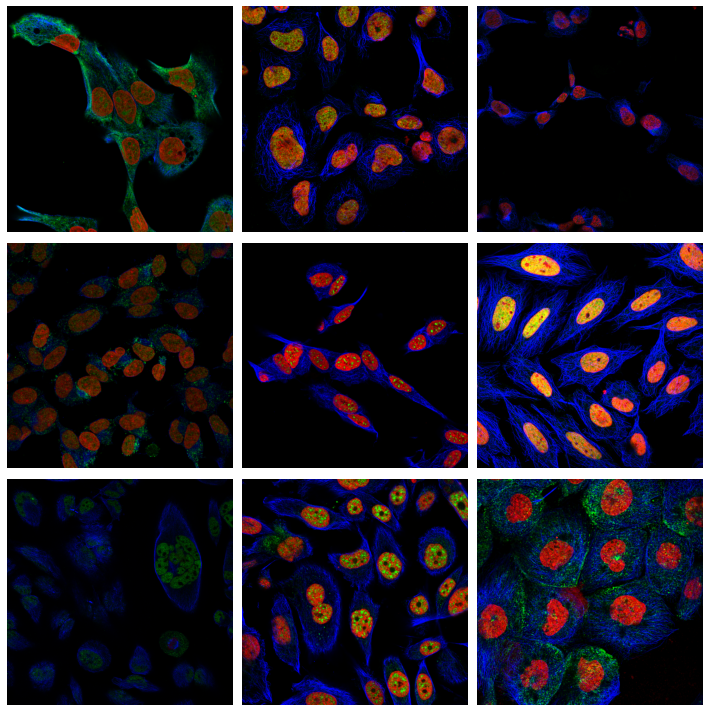

In [14]:
display_images(train_df['ID'].to_list())

In [15]:
# save_RGBY_images(train_df['ID'].to_list())

### Obtaining images from HPA Public

In [22]:
# celllines = ['A-431', 'A549', 'EFO-21', 'HAP1', 'HEK 293', 'HUVEC TERT2', 'HaCaT', 'HeLa', 'PC-3', 'RH-30', 'RPTEC TERT1', 'SH-SY5Y', 'SK-MEL-30', 'SiHa', 'U-2 OS', 'U-251 MG', 'hTCEpi']

# extra_df = pd.read_csv(os.path.join(PATH, 'extra_images.csv'))
# extra_df = extra_df.dropna().reset_index(drop=True)
# extra_labels = pd.DataFrame.from_records(extra_df['Label_idx'].apply(label_splitter))
# extra_df = pd.concat([extra_df, extra_labels], axis=1)
# extra_df['multiclass'] = extra_df.iloc[:, 5:25].sum(axis=1)

# condition1 = (extra_df['in_trainset']==False)
# extra_df = extra_df[condition1]
# condition2 = (extra_df[0]==1)
# condition3 = (extra_df[16]==1)
# drop_list = set(extra_df[condition2].index.to_list() + extra_df[condition3].index.to_list())
# extra_df = extra_df[~extra_df.index.isin(drop_list)]
# extra_df = extra_df[extra_df['Cellline'].isin(celllines)]

# counts = []
# for column in range(0,19):
#     counts.append(extra_df[column].sum(axis=0))

# count_df = pd.DataFrame({'label': range(0,19), 'count':counts})

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,15))
# sns.barplot(data=count_df, x='label', y='count', ax=ax1)
# ax1.set_title('Label Distribution')
# sns.countplot(x=extra_df['multiclass'], ax=ax2)
# ax2.set_title('Multi-label Distribution')
# ax2.set_xlabel('labels per image')
# plt.show()